In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np

import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import glob
from tqdm import tqdm
from collections import OrderedDict, defaultdict
from IPython.display import clear_output
import time
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim 
from collections import deque

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 
device

device(type='cuda')

In [3]:
files_eating=glob.glob("clips_eating/"+"*")
files_noteating=glob.glob("clips_noteating/"+"*")

len(files_eating), len(files_noteating)

(100, 25)

In [4]:
pose = mp.solutions.pose.Pose(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5)
def extract_keypoints(image_rgb): 
    try:
        results = pose.process(image_rgb)
        landmarks=results.pose_landmarks.landmark
    except Exception as e:
        # print('Error file=', fn)
        # print('Error=', e)
        return None
    xys=[]
    for landmark in landmarks:
        xys.append([landmark.x, landmark.y])
    xys=np.array(xys)
    return xys

In [5]:
def extract_imgs(video_fn, skip_frames=1):
    video=cv2.VideoCapture(video_fn)
    imgs=[]
    frame_count=0
    while(video.isOpened()):
        ret, frame = video.read()
        if ret==False: break
        if frame_count%skip_frames==0:
            imgs.append(frame)
        frame_count+=1
    video.release() 
    return imgs

In [6]:
def img2kps(img):
    image_rgb=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    xys=extract_keypoints(image_rgb)
    if xys is None: 
        return None

    xys=xys[:25].ravel() #first 25 keypoints
    return xys

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [7]:
def action_imgs_to_kps(action_imgs):
    action=[]
    for i, img in enumerate(action_imgs): 
        image_rgb=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        xys=extract_keypoints(image_rgb)
        if xys is None: 
            print('Error frame=',i)
            continue

        xys=xys[:25].ravel() #first 25 keypoints
        
        action.append(xys)
    action=np.array(action)
    return action

In [8]:
skip_frames=2

file=files_eating[33]
imgs=extract_imgs(file)
action_imgs= imgs[0:len(imgs):skip_frames]

action=action_imgs_to_kps(action_imgs)
action.shape

(65, 50)

In [9]:
X=torch.tensor(action).float()
X.shape         

torch.Size([65, 50])

In [10]:
seq_len=30

tx=X[:seq_len]
tx.shape

torch.Size([30, 50])

In [11]:
class LSTM(nn.Module):
    
    def __init__(self,input_dim,hidden_dim,output_dim,layer_num, seq_len):
        super(LSTM,self).__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.lstm = torch.nn.LSTM(input_dim,hidden_dim,layer_num,batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim,output_dim)
        self.bn = nn.BatchNorm1d(seq_len)
        
    def forward(self,inputs):
        x = self.bn(inputs)
        lstm_out,(hn,cn) = self.lstm(x)
        out = self.fc(lstm_out[:,-1,:])
        return out

In [12]:
n_hidden = 128
n_joints = 25*2
n_categories = 2
n_layer = 3
seq_len = 30
rnn = LSTM(n_joints,n_hidden,n_categories,n_layer, seq_len)
rnn.to(device)

LSTM(
  (lstm): LSTM(50, 128, num_layers=3, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
  (bn): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [13]:
# load model
rnn.load_state_dict(torch.load('lstm_model_eatnot1.pth'))         

<All keys matched successfully>

In [14]:
def view_imgs_as_video(imgs, delay=0.05):
    for img in imgs:
        clear_output(wait=True)
        plt.imshow(img[:,:,::-1])
        plt.show()
        time.sleep(delay)

In [15]:
tx=tx.reshape(1,seq_len,-1)
tx.shape    

torch.Size([1, 30, 50])

In [17]:
input_sequence = tx.to(device)  
output = rnn(input_sequence)
po=output.argmax(axis=1)
guess=po.item()
guess

1

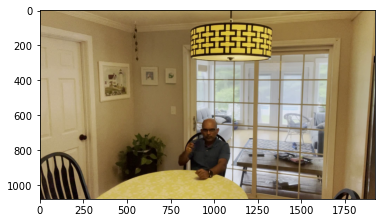

65


In [18]:
imgs=extract_imgs(file)
action_imgs= imgs[0:len(imgs):skip_frames]
view_imgs_as_video(action_imgs)

print( len(action_imgs) )

In [19]:
action=action_imgs_to_kps(action_imgs)

seq_len=30
tx=torch.tensor(action[:seq_len]).float()
tx=tx.reshape(1,seq_len,-1)
 
output = rnn(tx.to(device))
guess=output.argmax(axis=1).item() 
guess

1

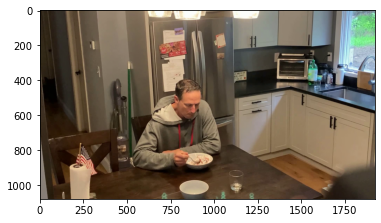

82


In [20]:
imgs=extract_imgs(files_noteating[10])
action_imgs= imgs[0:len(imgs):skip_frames]
view_imgs_as_video(action_imgs)

print( len(action_imgs) )

In [21]:
action=action_imgs_to_kps(action_imgs)

seq_len=30
tx=torch.tensor(action[:seq_len]).float()
tx=tx.reshape(1,seq_len,-1)
 
output = rnn(tx.to(device))
guess=output.argmax(axis=1).item() 
guess

0

In [20]:
file='clips_eating/Morning cereal-Me_7.mp4'

In [21]:

imgs=extract_imgs(file)

In [25]:
def draw_points(image, landmarks, keys=None):
    mp_drawing = mp.solutions.drawing_utils
    drawing_spec = mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=2)
 
    if keys==None: keys=[ i for i in range(len(landmarks)) ]
     
    for key in keys:
        landmark_point = landmarks[key]
        x_px, y_px = int(landmark_point.x * image.shape[1]), int(landmark_point.y * image.shape[0])
        cv2.circle(image, (x_px, y_px), drawing_spec.circle_radius, drawing_spec.color, drawing_spec.thickness)
    return image 

In [20]:
pose = mp.solutions.pose.Pose(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5)



In [24]:
imgs2=[]
for i, img in enumerate(imgs): 
    image_rgb=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = pose.process(image_rgb)
    landmarks=results.pose_landmarks.landmark[:25]
    img=draw_points(img, landmarks)
    imgs2.append(img)

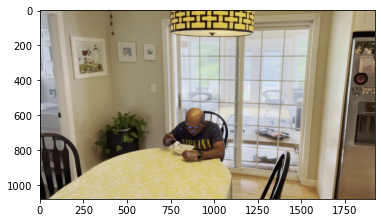

In [25]:
view_imgs_as_video(imgs2, delay=0.05)

In [22]:
import imageio

In [27]:
# #save images as video

# with imageio.get_writer('eating.mp4', mode='I', fps=10) as writer:
#     for img in imgs2:
#         writer.append_data(img[:,:,::-1])



### load a full video

In [23]:
# video_path = "/home/ns/activity_recog/data/Eating/Lunch-July 5.mov"
video_path = "/home/ns/activity_recog/data/Eating/Dain Eating 1.mp4"

In [24]:
#save video using imageio
import imageio


In [24]:
#get frame rate
video=cv2.VideoCapture(video_path)
fps = video.get(cv2.CAP_PROP_FPS)
fps=int(fps)
fps 

30

In [29]:
#cv2 read and show video
video=cv2.VideoCapture(video_path)
fps = video.get(cv2.CAP_PROP_FPS)
fps=int(fps)

q = deque(maxlen=seq_len)
frame_count=0
skip_frames=2

text='not eat'
ds=[]
landmarks=None
writer = imageio.get_writer('eat_noneat_inference.mp4', fps=fps)

while(video.isOpened()):
    ret,frame=video.read()
    if ret==False: break

    h,w,_= frame.shape
    scale=0.5
    

    todraw=cv2.resize(frame,(int(w*scale), int(h*scale) ))
    
    if frame_count%skip_frames==0: 
        # a=img2kps(frame)
        img=frame 
        image_rgb=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        xys=None
        try:
            results = pose.process(image_rgb)
            landmarks=results.pose_landmarks.landmark

            # todraw=draw_points(todraw, landmarks)

            xys=[ (landmark.x, landmark.y) for landmark in landmarks ] 
            xys=np.array(xys)
            xys=xys[:25].ravel() #first 25 keypoints
        except Exception as e:
            pass 

        a=xys
 
        if a is not None:
            q.append(a)


        if len(q)==seq_len: 
            # break
            action=np.array(q)
            tx=action.reshape(1,seq_len,-1)
            tx=torch.from_numpy(tx).float().to(device)
            output = rnn(tx)
            po=output.argmax(axis=1)
            guess=po.item()
            ds.append(guess)

            #add text to image
            font = cv2.FONT_HERSHEY_SIMPLEX 
            if guess==0:
                text='not eat'
            else:
                text='eat'
    color=(255, 0, 0)
    if text=='eat':
        color=(0, 255, 0)
    else:
        color=(0, 0, 255)

    todraw = cv2.putText(todraw, text, (50, 50), font,1, color , 2, cv2.LINE_AA)
    

    if landmarks is not None:
        todraw=draw_points(todraw, landmarks)

    # cv2.imshow('frame',todraw)
    writer.append_data(todraw[:,:,::-1])

    if cv2.waitKey(25) & 0xFF==ord('q'):
        break
    frame_count+=1
    
cv2.destroyAllWindows()
video.release()
writer.close()

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (960, 540) to (960, 544) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [103]:
cv2.destroyAllWindows()
video.release()

In [26]:
font = cv2.FONT_HERSHEY_SIMPLEX 

### Live camera

In [27]:
cap = cv2.VideoCapture(0)

q = deque(maxlen=seq_len)
frame_count=0
skip_frames=2

text='not eat'
ds=[]
landmarks=None

while cap.isOpened(): 
    ret, frame = cap.read()
    if ret==False: continue

    h,w,_= frame.shape
    # scale=0.5
    scale=1
    

    todraw=cv2.resize(frame,(int(w*scale), int(h*scale) ))
    font = cv2.FONT_HERSHEY_SIMPLEX 
    
    if frame_count%skip_frames==0: 
        img=frame 
        image_rgb=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        xys=None
        try:
            results = pose.process(image_rgb)
            landmarks=results.pose_landmarks.landmark
            xys=[ (landmark.x, landmark.y) for landmark in landmarks ] 
            xys=np.array(xys)
            xys=xys[:25].ravel() #first 25 keypoints
        except Exception as e:
            pass 

        a=xys
 
        if a is not None:
            q.append(a)


        if len(q)==seq_len: 
            # break
            action=np.array(q)
            tx=action.reshape(1,seq_len,-1)
            tx=torch.from_numpy(tx).float().to(device)
            output = rnn(tx)
            po=output.argmax(axis=1)
            guess=po.item()
            ds.append(guess)

            #add text to image
            
            if guess==0:
                text='not eat'
            else:
                text='eat'
    color=(255, 0, 0)
    if text=='eat':
        color=(0, 255, 0)
    else:
        color=(0, 0, 255)

    todraw = cv2.putText(todraw, text, (50, 50), font,1, color , 2, cv2.LINE_AA)
    if landmarks is not None:
        todraw=draw_points(todraw, landmarks)

    cv2.imshow('frame',todraw)

    if cv2.waitKey(25) & 0xFF==ord('q'):
        break
    frame_count+=1
    
cv2.destroyAllWindows()
cap.release()


QObject::moveToThread: Current thread (0x55feaec37610) is not the object's thread (0x55feaeabf0b0).
Cannot move to target thread (0x55feaec37610)

QObject::moveToThread: Current thread (0x55feaec37610) is not the object's thread (0x55feaeabf0b0).
Cannot move to target thread (0x55feaec37610)

QObject::moveToThread: Current thread (0x55feaec37610) is not the object's thread (0x55feaeabf0b0).
Cannot move to target thread (0x55feaec37610)

QObject::moveToThread: Current thread (0x55feaec37610) is not the object's thread (0x55feaeabf0b0).
Cannot move to target thread (0x55feaec37610)

QObject::moveToThread: Current thread (0x55feaec37610) is not the object's thread (0x55feaeabf0b0).
Cannot move to target thread (0x55feaec37610)

QObject::moveToThread: Current thread (0x55feaec37610) is not the object's thread (0x55feaeabf0b0).
Cannot move to target thread (0x55feaec37610)

QObject::moveToThread: Current thread (0x55feaec37610) is not the object's thread (0x55feaeabf0b0).
Cannot move to tar

In [35]:
cv2.destroyAllWindows()
cap.release()

In [22]:
cap = cv2.VideoCapture(0)

 
while cap.isOpened(): 
    ret, frame = cap.read()
    # if ret==False: continue
    cv2.imshow('frame',frame)

cv2.destroyAllWindows()
cap.release()

[ WARN:0@222.482] global cap_v4l.cpp:1119 tryIoctl VIDEOIO(V4L2:/dev/video0): select() timeout.


error: OpenCV(4.7.0) /io/opencv/modules/highgui/src/window.cpp:971: error: (-215:Assertion failed) size.width>0 && size.height>0 in function 'imshow'


In [23]:
cv2.destroyAllWindows()
cap.release()

In [33]:
import cv2
  
  
# define a video capture object
vid = cv2.VideoCapture(0)
  
while vid.isOpened():
      
    # Capture the video frame
    # by frame
    ret, frame = vid.read()

    if  not ret:
        print('frame is none')
        continue 
  
    # Display the resulting frame
    cv2.imshow('frame', frame)
      
    # the 'q' button is set as the
    # quitting button you may use any
    # desired button of your choice
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
  

vid.release()
# Destroy all the windows
cv2.destroyAllWindows()

QObject::moveToThread: Current thread (0x7faa6c0033a0) is not the object's thread (0x55d63cf65560).
Cannot move to target thread (0x7faa6c0033a0)

QObject::moveToThread: Current thread (0x7faa6c0033a0) is not the object's thread (0x55d63cf65560).
Cannot move to target thread (0x7faa6c0033a0)

QObject::moveToThread: Current thread (0x7faa6c0033a0) is not the object's thread (0x55d63cf65560).
Cannot move to target thread (0x7faa6c0033a0)

QObject::moveToThread: Current thread (0x7faa6c0033a0) is not the object's thread (0x55d63cf65560).
Cannot move to target thread (0x7faa6c0033a0)

QObject::moveToThread: Current thread (0x7faa6c0033a0) is not the object's thread (0x55d63cf65560).
Cannot move to target thread (0x7faa6c0033a0)

QObject::moveToThread: Current thread (0x7faa6c0033a0) is not the object's thread (0x55d63cf65560).
Cannot move to target thread (0x7faa6c0033a0)

QObject::moveToThread: Current thread (0x7faa6c0033a0) is not the object's thread (0x55d63cf65560).
Cannot move to tar

In [27]:
cv2.destroyAllWindows()
vid.release()